<a href="https://colab.research.google.com/github/hughman1986/DiagnosisModel_ONNX_Converter/blob/main/%E8%A8%BA%E6%96%B7%E7%AE%97%E6%B3%95%E6%B8%AC%E8%A9%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/audio/stable/functional.html#torchaudio.functional.linear_fbanks



In [3]:
import torch
from torch import Tensor

import torchaudio
from torchaudio import functional as F

import matplotlib.pyplot as plt
import numpy as np


## 測試驗證特徵萃取流程
1. torch 內建 Filter Bank 生成函數 
2. torch 內建 FFT轉換 
3. torch 內建 p-norm 計算 

In [17]:
# Filter Bank 函數生成 
fb = F.linear_fbanks(
    n_freqs= 256,
    f_min= 0,
    f_max= 5600/2,
    n_filter= 30,
    sample_rate= 5600)

fb.shape

torch.Size([256, 30])

In [20]:
# 生成sin波訊號轉換FFT 
x = np.linspace(-5000*np.pi, 5000*np.pi, 512)
numpy_sin = np.sin(x)

# 轉成 torch.tensor 
tensor_sin = torch.tensor(numpy_sin , dtype=torch.float32)
print("tensor_sin", tensor_sin.shape)

# 在 使用 torch 的FFT轉換, 並取 magnitude 
abs_fft = torch.fft.fft(tensor_sin).abs()[0:256]
print("abs_fft", abs_fft.shape)

# 測試用 filter bank 進行特徵萃取 
feature_vec = (fb * abs_fft.reshape((256,1)) ).sum(0)
print("feature_vec", feature_vec)

tensor_sin torch.Size([512])
abs_fft torch.Size([256])
feature_vec tensor([  0.5227,   1.0632,   1.6451,   2.3012,   3.0597,   3.9727,   5.1347,
          6.6953,   8.9656,  12.5186,  19.2355,  37.7003, 296.9919, 214.8637,
         36.9206,  22.7519,  17.0133,  13.8699,  11.8458,  10.4850,   9.5012,
          8.7881,   8.2013,   7.7593,   7.4171,   7.1604,   6.9583,   6.7931,
          6.6876,   6.6240])


In [21]:
# 測試驗證 用 torch.cdist (p-norm) 計算距離, p=2代表計算的是 L2-nrom
vec_distance = torch.cdist(feature_vec.reshape(1,30), feature_vec.reshape(1,30), p=2)
print("vec_distance",vec_distance)

vec_distance tensor([[0.]])


## 建立nn模型 
1. 測試驗證 可行性, 已用 1x256 的兩個input確認可行 
2. 改成 可以輸入三軸FFT跟 匯入特徵組的方式進行診斷


### 用 1x256 的兩個input確認

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchaudio import functional as F

class IDMSDiagnosisEngine(nn.Module):

    def __init__(self):
        super(IDMSDiagnosisEngine, self).__init__()
        self.filter_bank = F.linear_fbanks(n_freqs= 256,f_min= 0,f_max= 5600/2,n_filter= 30,sample_rate= 5600)
        
    def GaussianFunction_abc(self, input_x ,a=1.,b=0.,c=1.5):
        y = torch.exp( -0.5 * (input_x - b) / c * (input_x - b) / c );
        return y

    def forward_one(self, input_FFT):
        print("1" , input_FFT.shape)

        feature_vec = (self.filter_bank * input_FFT.reshape((256,1)) ).sum(0) 
        return feature_vec

    def forward(self, input_FFT1, input_FFT2):
        out1 = self.forward_one(input_FFT1)
        out2 = self.forward_one(input_FFT2)
        vec_distance = torch.cdist(out1.reshape(1,30), out2.reshape(1,30), p=2)
        out = 100 * self.GaussianFunction_abc( vec_distance )
        return out

IDMSEngine = IDMSDiagnosisEngine()


## 模型另存成 ONNX

In [9]:
from torch.autograd import Variable

model_onnx_path = "torch_model.onnx"
input_shape = ( 1, 256)
dummy_input = Variable(torch.randn(1, *input_shape))

torch.onnx.export(
    model = IDMSEngine, 
    args = (dummy_input, dummy_input), 
    f = "IDMSEngine.onnx",
    verbose=False)

# ONNX模型可以用Netron視覺化出來 https://netron.app/ 

1 torch.Size([1, 1, 256])
1 torch.Size([1, 1, 256])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


(1, 1, 256)

## 另外生成Raw data, 驗證 IDMSEngine 診斷的可行性 

In [10]:
import numpy as np

# 生成數據
def Sin_gen(n=60):
    list_data = []
    for i in range(n) :
        x = np.linspace((-1000+100*n)*np.pi, (5000+100*n)*np.pi, 512)
        numpy_sin = np.sin(x)
        list_data.append(numpy_sin)
    tensor_sin = torch.tensor(list_data, dtype=torch.float32)
    return tensor_sin
ss = Sin_gen(60)

abs_fft_ss = torch.fft.fft(ss).abs()[:,0:256]
print(abs_fft_ss.shape)


torch.Size([60, 256])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # Remove the CWD from sys.path while we load stuff.


In [11]:
HealthScore = IDMSEngine(abs_fft_ss[10],abs_fft_ss[20]) 
print(HealthScore)

1 torch.Size([256])
1 torch.Size([256])
tensor([[100.]])


Text(0.5, 1.0, 'feature vector')

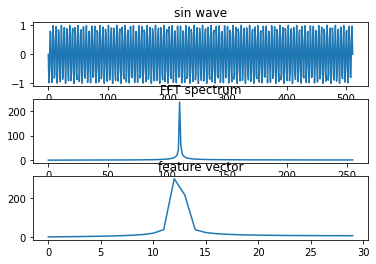

In [16]:
plt.subplot(3, 1, 1)
plt.plot( tensor_sin )
plt.title("sin wave")

plt.subplot(3, 1, 2)
plt.plot( abs_fft )
plt.title("FFT spectrum")

plt.subplot(3, 1, 3)
plt.plot( feature_vec )
plt.title("feature vector")

### [參考用] 孿生one shot模型 
https://github.com/fangpin/siamese-pytorch/blob/master/model.py

https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/

https://colab.research.google.com/github/maticvl/dataHacker/blob/master/pyTorch/014_siameseNetwork.ipynb#scrollTo=U7bz8o__2JKn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #  return self.sigmoid(out)
        return out
